In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import statsmodels.api as sm

In [46]:
def print_nulls(df):
    
    out = df.isnull().sum()*100/df.isnull().isnull().count()
    
    pd.set_option('display.max_rows', len(out))
    print(out)
    pd.reset_option('display.max_rows')

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
def print_outliers(df):
    
    print('Continuious Variables', '\n')
    
    for column in df.select_dtypes(include=['int64', 'float64', 'float']):
        print(column, df.columns.get_loc(column))
        for threshold in [95, 90, 85, 80, 75]:
            upper_value = np.percentile(df[column], [threshold])[0]
            print('Beyond the lower {}th percentile there are {} outliers'.format(threshold, 
                len((np.where((df[column] > upper_value))[0]))
            ))
        if (df[column].nunique() < 20):
            print('\n')
            print('Possible Categorical Variable')
            print('There are {} unique values'.format(df[column].nunique()))
            print(df[column].value_counts())
        print('\n')
        
        
    
    print('Categorical Variables', '\n')
    
    for column in df.select_dtypes(include='object'):
        print(column)
        print('There are {} unique values'.format(df[column].nunique()))
        if df[column].nunique() < 20:
            print(df[column].value_counts())
            print('\n')

### 1. Load the dataset from the Thinkful PostgreSQL database.

Investigate the data, and do any necessary data cleaning.
Explore the data and find some variables that you think would be useful in predicting house prices.
Build your initial model using these features and estimate the parameters using OLS.
Spend up to 4 hours on this assignment. You will submit the notebook after the assessment questions.

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  houseprices
'''

df = pd.read_sql_query(query1, con=engine)
engine.dispose()

### 2. Investigate the data, and do any necessary data cleaning.

In [19]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mssubclass     1460 non-null   int64  
 1   mszoning       1460 non-null   object 
 2   lotfrontage    1201 non-null   float64
 3   lotarea        1460 non-null   int64  
 4   street         1460 non-null   object 
 5   alley          91 non-null     object 
 6   lotshape       1460 non-null   object 
 7   landcontour    1460 non-null   object 
 8   utilities      1460 non-null   object 
 9   lotconfig      1460 non-null   object 
 10  landslope      1460 non-null   object 
 11  neighborhood   1460 non-null   object 
 12  condition1     1460 non-null   object 
 13  condition2     1460 non-null   object 
 14  bldgtype       1460 non-null   object 
 15  housestyle     1460 non-null   object 
 16  overallqual    1460 non-null   int64  
 17  overallcond    1460 non-null   int64  
 18  yearbuil

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [ ]:
print_outliers(df)

In [5]:
# drop the id variable
df.drop('id', axis=1, inplace=True)

In [ ]:
# Sort my features into categorical and continuous

In [2]:
def get_cats_conts_unsorted(df):
     
        # Some paramater tuning is no doubt called for at some point. For now these are rough
        # values for sorting and we will clean up the rest manually. Better than doing the whole
        # thing manually!
        
    cats = []
    conts = []
    unsorted = []
    
    
    for column in df.columns:
        if df[column].dtype != 'object' and df[column].nunique() > 5:
            conts.append(column)
            
        elif df[column].nunique() < 5 or df[column].dtype == 'object':
            cats.append(column)
        
        elif df[column].nunique() <  len(df)/20:
            unsorted.append(column)
            
            # there is some room here to integrate a process for maually assiging categorical
            # or continuous to the unsorted columns.
            
            
    print('{} cats'.format(len(cats))
         , '\n', '{} conts'.format(len(conts))
         , '\n', '{} unsorted'.format(len(unsorted))
         )
    
    return cats, conts, unsorted

In [3]:
cats, conts, unsorted = get_cats_conts_unsorted(df)
    

NameError: name 'df' is not defined

In [8]:
df.loc[:, unsorted].nunique().sort_values(ascending=False)

bsmtfinsf2       144
enclosedporch    120
yearbuilt        112
lotfrontage      110
garageyrblt       97
screenporch       76
yearremodadd      61
neighborhood      25
lowqualfinsf      24
miscval           21
threessnporch     20
exterior2nd       16
mssubclass        15
exterior1st       15
totrmsabvgrd      12
mosold            12
overallqual       10
dtype: int64

In [9]:
new_cats = ['mssubclass', 'mosold', 'overallqual', 'totrmsabvgrd', 'exterior2nd', 'exterior1st', 'neighborhood']

new_conts =['lotfrontage', 'yearbuilt', 'garageyrblt', 'yearremodadd', 'miscval'
            ,'screenporch', 'lowqualfinsf', 'threessnporch', 'bsmtfinsf2', 'enclosedporch', ]

for cat in new_cats: 
    cats.append(cat)

for cont in new_conts:
    conts.append(cont)

In [10]:
# check to make sure our two buckets contain the right number of features
len(cats) + len(conts)

80

In [11]:
if 'saleprice' in conts:
    print('yes')

yes


In [49]:
print_nulls(df.loc[:, cats])

mszoning          0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallcond       0.000000
roofstyle         0.000000
roofmatl          0.000000
masvnrtype        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
bsmtqual          2.534247
bsmtcond          2.534247
bsmtexposure      2.602740
bsmtfintype1      2.534247
bsmtfintype2      2.602740
heating           0.000000
heatingqc         0.000000
centralair        0.000000
electrical        0.068493
bsmtfullbath      0.000000
bsmthalfbath      0.000000
fullbath          0.000000
halfbath          0.000000
bedroomabvgr      0.000000
kitchenabvgr      0.000000
kitchenqual       0.000000
functional        0.000000
fireplaces        0.000000
f

According to the data dictionary null values in this data set indicate that this feature is not present. This makes filling simple.

In [54]:
df.loc[:, cats] = df.loc[:, cats].fillna('feature not included')

In [55]:
df['alley'].unique()

array(['feature not included', 'Grvl', 'Pave'], dtype=object)

In [90]:
print_outliers(df.loc[:, conts])

Continuious Variables 

lotarea 0
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile there are 146 outliers
Beyond the lower 85th percentile there are 219 outliers
Beyond the lower 80th percentile there are 292 outliers
Beyond the lower 75th percentile there are 365 outliers


masvnrarea 1
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile there are 146 outliers
Beyond the lower 85th percentile there are 219 outliers
Beyond the lower 80th percentile there are 289 outliers
Beyond the lower 75th percentile there are 364 outliers


bsmtfinsf1 2
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile there are 146 outliers
Beyond the lower 85th percentile there are 219 outliers
Beyond the lower 80th percentile there are 292 outliers
Beyond the lower 75th percentile there are 365 outliers


bsmtunfsf 3
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile t

/home/owen/bin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/owen/bin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


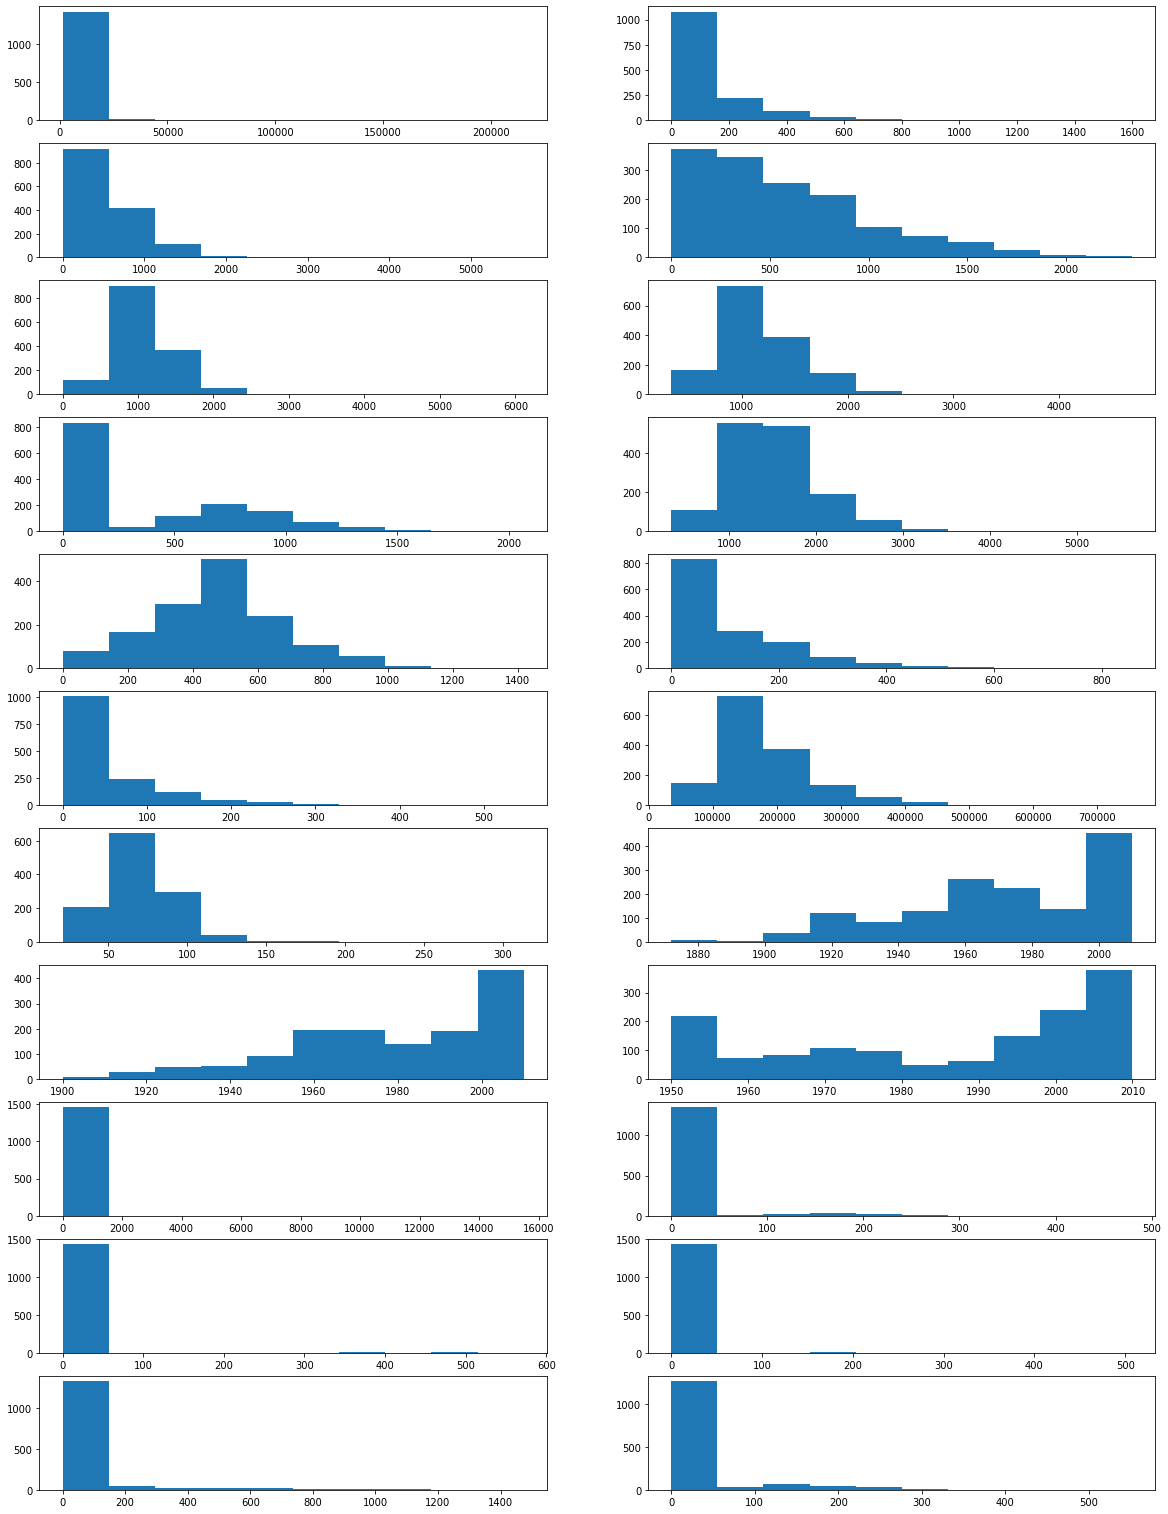

In [15]:
plt.figure(figsize=(20,55))

for i, cont in enumerate(conts):  
    plt.subplot(22, 2, i+1)
    plt.hist(df[cont])
    plt.title(cont)

plt.show()

All of these columns contain true zeros so we don't want to treat those values. We will treat the outliers at the upper bound. We will not treat any of the date variables and will treat the rest of the continuous variables.

In [20]:
conts

['lotarea',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'grlivarea',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'saleprice',
 'lotfrontage',
 'yearbuilt',
 'garageyrblt',
 'yearremodadd',
 'miscval',
 'screenporch',
 'lowqualfinsf',
 'threessnporch',
 'bsmtfinsf2',
 'enclosedporch']

In [28]:
treat_cont_columns = ['lotarea',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'grlivarea',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'saleprice',
 'lotfrontage',
 'miscval',
 'screenporch',
 'lowqualfinsf',
 'threessnporch',
 'bsmtfinsf2',
 'enclosedporch']

In [58]:
for column in treat_cont_columns:
    df.loc[:, column] = winsorize(df.loc[:, column], (0, .05))

In [60]:
print_outliers(df.loc[:, treat_cont_columns])

Continuious Variables 

lotarea 0
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile there are 146 outliers
Beyond the lower 85th percentile there are 219 outliers
Beyond the lower 80th percentile there are 292 outliers
Beyond the lower 75th percentile there are 365 outliers


masvnrarea 1
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile there are 146 outliers
Beyond the lower 85th percentile there are 219 outliers
Beyond the lower 80th percentile there are 289 outliers
Beyond the lower 75th percentile there are 364 outliers


bsmtfinsf1 2
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile there are 146 outliers
Beyond the lower 85th percentile there are 219 outliers
Beyond the lower 80th percentile there are 292 outliers
Beyond the lower 75th percentile there are 365 outliers


bsmtunfsf 3
Beyond the lower 95th percentile there are 0 outliers
Beyond the lower 90th percentile t

### 3. Explore the data and find some variables that you think would be useful in predicting house prices.

In [83]:
sns.set(font_scale=1)

In [86]:
def multivariate_visualization(df, target, cats, conts):

    if target in conts:
        
        # cont / cont
        
        map_df = df.loc[:, conts]
        map_df.set_index(target)
        
        plt.figure(figsize=(len(conts)*2, len(conts)*2))
        corr_map = map_df.corr()
        sns.set(font_scale=2.5)
        sns.heatmap(corr_map, square=True, annot=True, linewidths=.5,)
        
        
        # cont / cat
        plt.figure(figsize=(15, len(cats)*4))
        sns.set(font_scale=1.3)

        for i, feature in enumerate(cats):
            plt.subplot(len(cats), 1, i+1)
            sns.barplot(df[feature], df[target])
            plt.title(feature)
            plt.xlabel('')
            plt.xticks(rotation=90)
        plt.tight_layout(pad=0.3)
        plt.show()

    # elif target in cats:
    
    # need to write second half of the function

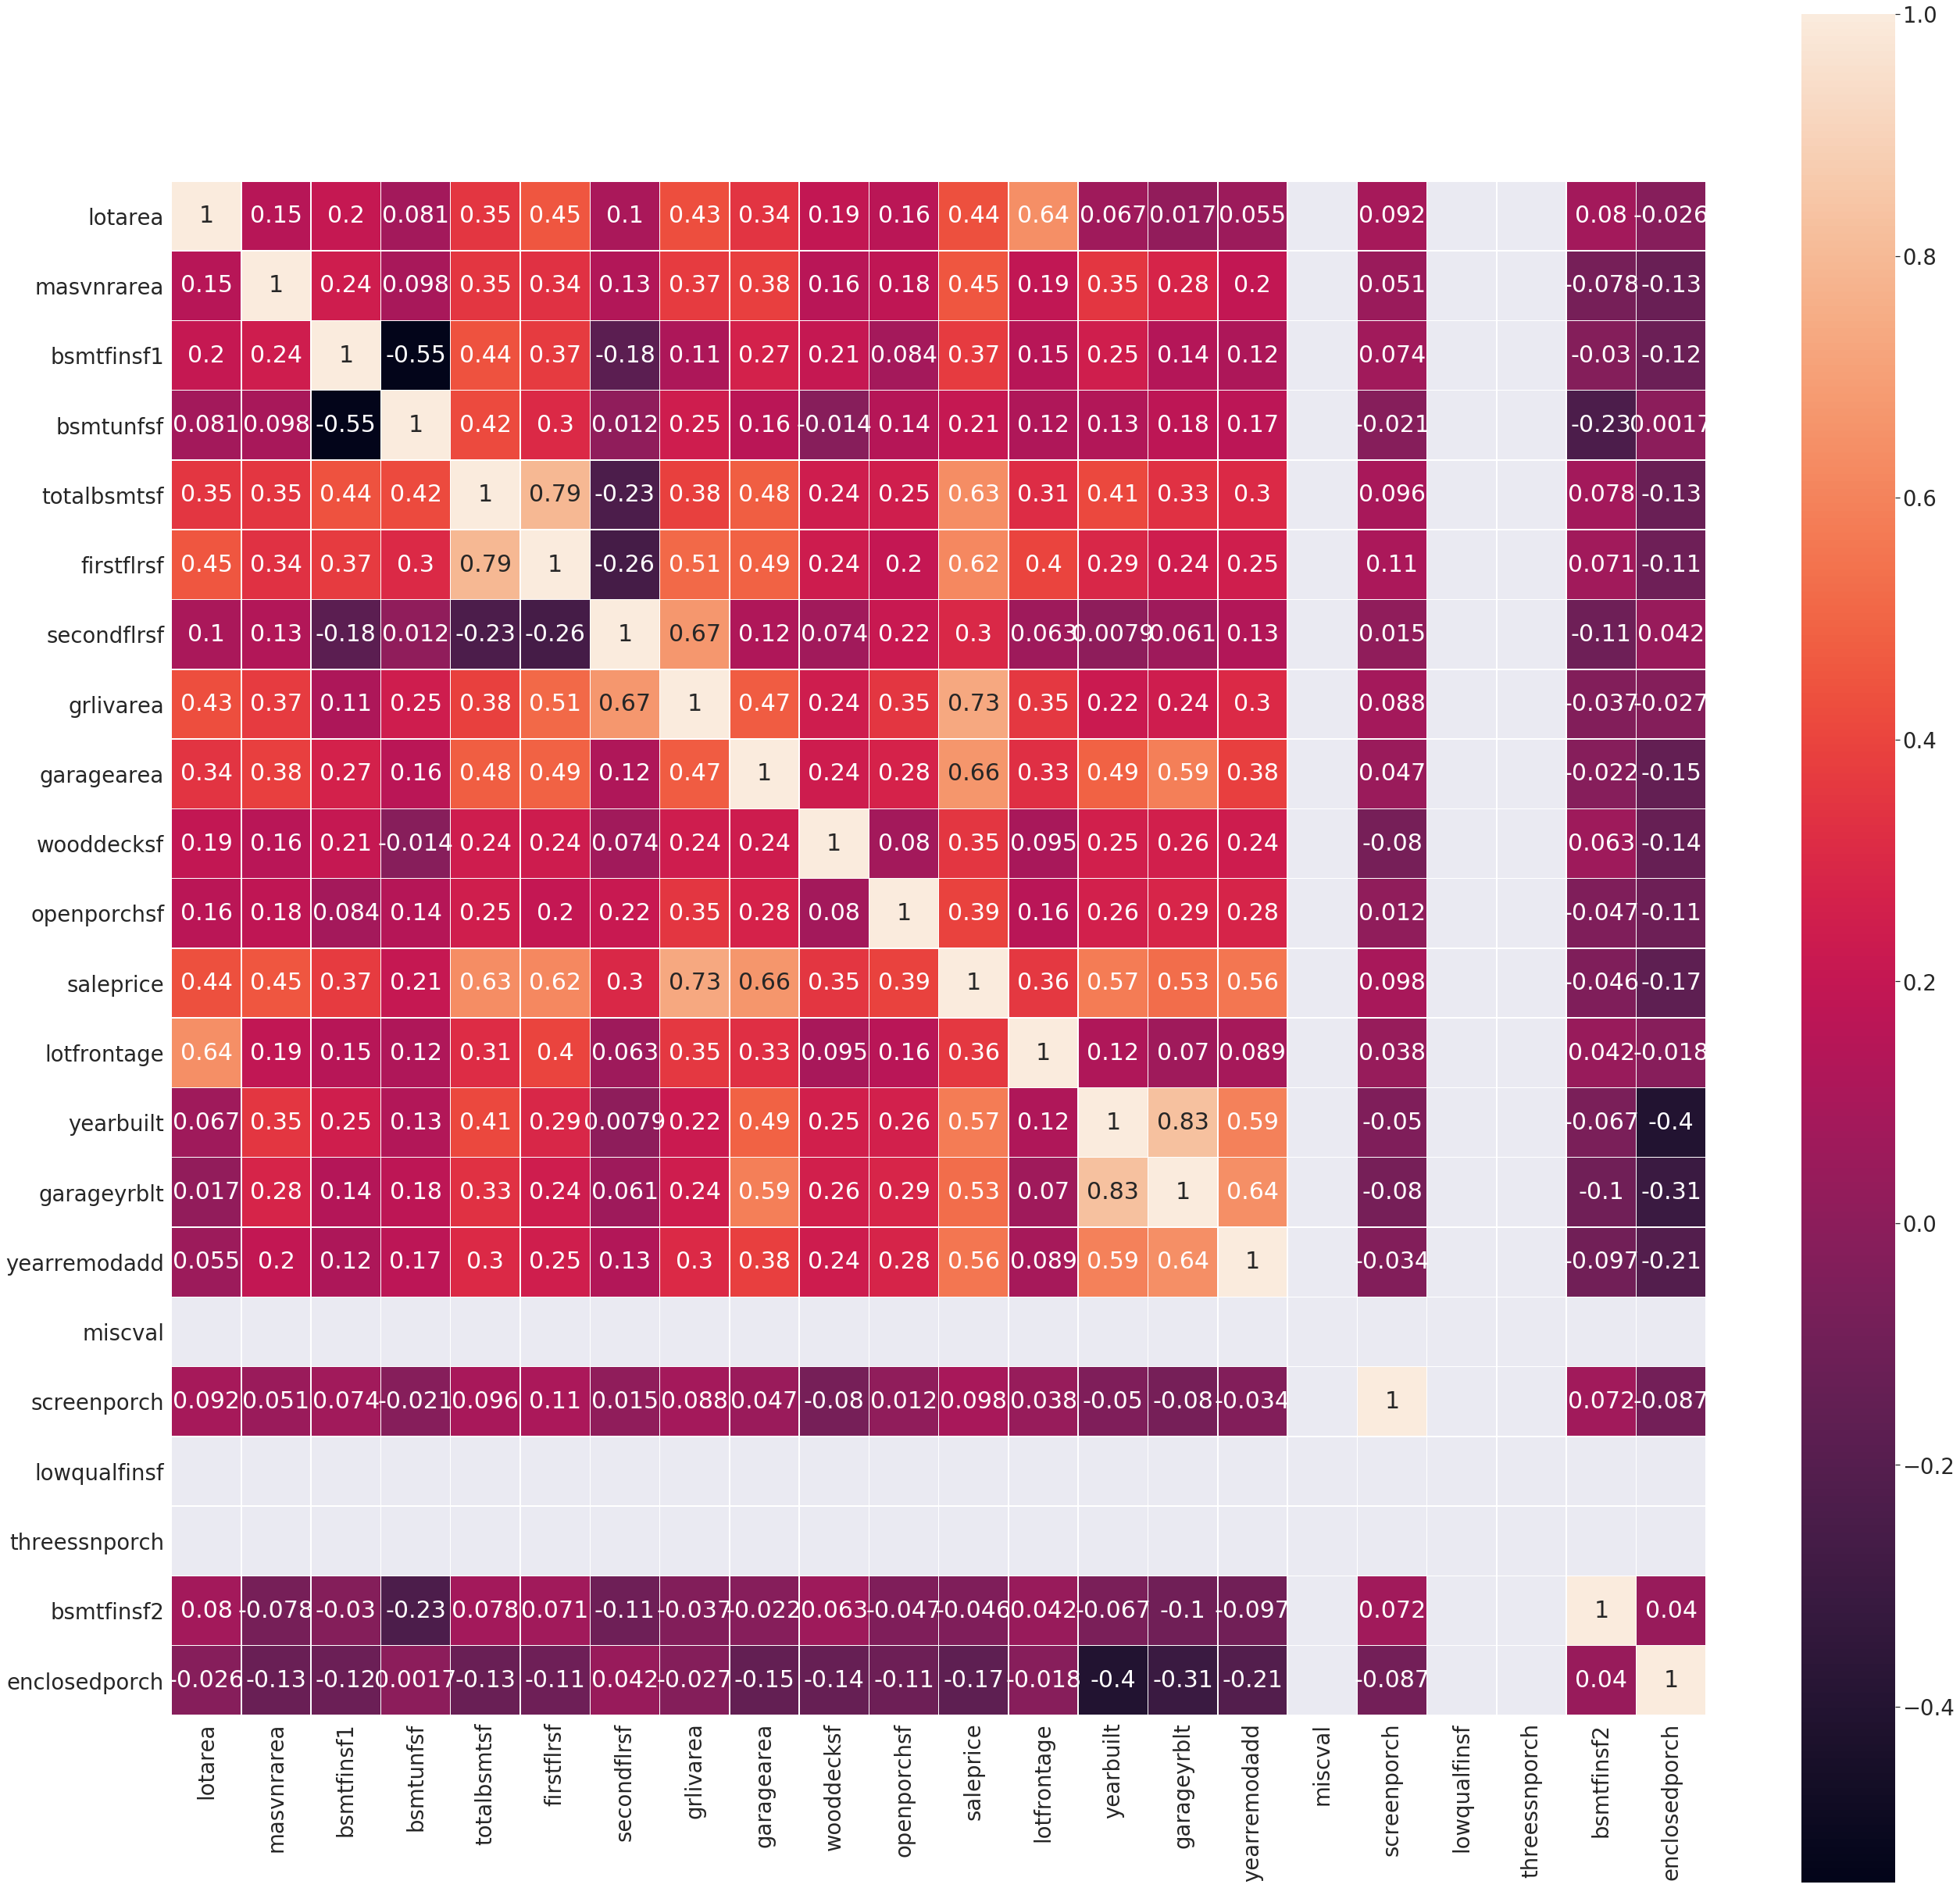

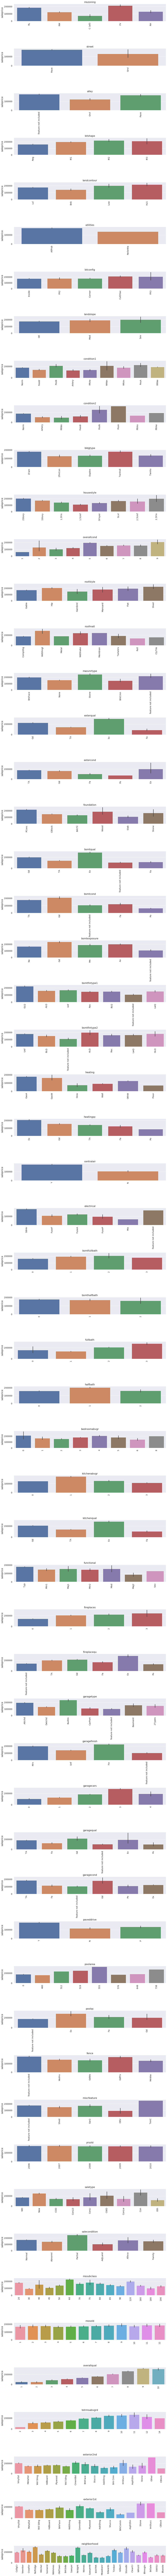

In [87]:
multivariate_visualization(df, 'saleprice', cats, conts)

### 4. Build your initial model using these features and estimate the parameters using OLS.

In [98]:
conts

['lotarea',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'grlivarea',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'saleprice',
 'lotfrontage',
 'yearbuilt',
 'garageyrblt',
 'yearremodadd',
 'miscval',
 'screenporch',
 'lowqualfinsf',
 'threessnporch',
 'bsmtfinsf2',
 'enclosedporch']

In [148]:
# Avoiding correlation between features is difficult with this dataset. PCA should be considered here.

# To test an intial model we will pull out a few key features

features = ['overallcond', 'totrmsabvgrd', 'neighborhood', 'yearremodadd', 'mszoning', 'saleprice']

In [163]:
untransformed = df.loc[:, features]

In [164]:
# reassign values for overall cond so that we don't have overlap between the dummy variables ie an overallcond
# of 5 with 5 totrmsabvgrd.

# In this case we will simply add 100 to the overallcond values. 

untransformed.loc[:, 'overallcond'] += 100

In [165]:
untransformed.head()

,overallcond,totrmsabvgrd,neighborhood,yearremodadd,mszoning,saleprice
0,105,8,CollgCr,2003,RL,208500
1,108,6,Veenker,1976,RL,181500
2,105,6,CollgCr,2002,RL,223500
3,105,7,Crawfor,1970,RL,140000
4,105,9,NoRidge,2000,RL,250000


In [168]:
data_df = untransformed['saleprice']

for column in untransformed:
    if column in cats:
        data_df = pd.concat([data_df, pd.get_dummies(untransformed[column], drop_first=True)]
                                  , axis=1)

In [169]:
data_df.head()

,saleprice,102,103,104,105,106,107,108,109,3,...,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,FV,RH,RL,RM
0,208500,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,181500,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,223500,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,140000,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,250000,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [170]:
y = data_df['saleprice']
X = data_df.drop(['saleprice'], axis=1)

In [171]:
lrm = linear_model.LinearRegression()
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [173]:
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     75.49
Date:                Mon, 24 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:14:27   Log-Likelihood:                -17348.
No. Observations:                1460   AIC:                         3.479e+04
Df Residuals:                    1412   BIC:                         3.505e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.567e+04   5.42e+04      1.027      0.305   -5.07e+04    1.62e+05
102         1.807e+04   3.96e+04      0.457      0.648   -5.95e+04    9.57e+04
103         1.266e+04   3.66e+04      0.346      0.729   -5.91e+04    8.44e+04
104         1.846e+04   3.63e+04      0.509      0.611   -5.27e+04    8.97e+04
105         4.265e+04    3.6e+04      1.184      0.236    -2.8e+04    1.13e+05
106         4.136e+04    3.6e+04      1.148      0.251   -2.93e+04    1.12e+05
107         4.871e+04    3.6e+04      1.351      0.177    -2.2e+04    1.19e+05
108         5.126e+04   3.62e+04      1.414      0.158   -1.98e+04    1.22e+05
109          8.95e+04   3.68e+04      2.432      0.015    1.73e+04    1.62e+05
3           1.933e+04   3.82e+04      0.506      0.613   -5.56e+04    9.43e+04
4           3.509e+04   3.69e+04      0.952      0.341   -3.72e+04    1.07e+05
5           4.597e+04   3.68e+04      1.249      0.212   -2.62e+04    1.18e+05
6           5.953e+04   3.68e+04      1.616      0.106   -1.27e+04    1.32e+05
7           8.013e+04   3.68e+04      2.175      0.030    7843.715    1.52e+05
8           9.336e+04   3.69e+04      2.533      0.011     2.1e+04    1.66e+05
9           1.047e+05    3.7e+04      2.830      0.005    3.21e+04    1.77e+05
10          1.163e+05   3.72e+04      3.128      0.002    4.34e+04    1.89e+05
11          1.285e+05   3.78e+04      3.402      0.001    5.44e+04    2.03e+05
12          1.148e+05   3.82e+04      3.001      0.003    3.98e+04     1.9e+05
14          1.578e+05   5.25e+04      3.002      0.003    5.47e+04    2.61e+05
Blueste    -3.837e+04   2.72e+04     -1.408      0.159   -9.18e+04    1.51e+04
BrDale     -7.724e+04   1.33e+04     -5.801      0.000   -1.03e+05   -5.11e+04
BrkSide    -5.685e+04   1.04e+04     -5.460      0.000   -7.73e+04   -3.64e+04
ClearCr     1.287e+04   1.11e+04      1.162      0.246   -8863.790    3.46e+04
CollgCr     3030.3594   9155.439      0.331      0.741   -1.49e+04     2.1e+04
Crawfor    -3639.0095   1.02e+04     -0.356      0.722   -2.37e+04    1.64e+04
Edwards    -5.758e+04   9513.915     -6.052      0.000   -7.62e+04   -3.89e+04
Gilbert    -1.379e+04   9570.928     -1.441      0.150   -3.26e+04    4984.193
IDOTRR     -7.248e+04   1.21e+04     -6.013      0.000   -9.61e+04   -4.88e+04
MeadowV      -6.6e+04   1.35e+04     -4.903      0.000   -9.24e+04   -3.96e+04
Mitchel    -2.987e+04   1.01e+04     -2.948      0.003   -4.97e+04   -9990.613
NAmes      -4.262e+04   9121.503     -4.672      0.000   -6.05e+04   -2.47e+04
NPkVill    -4.296e+04   1.48e+04     -2.903      0.004    -7.2e+04   -1.39e+04
NWAmes     -1.889e+04   9771.883     -1.933      0.053   -3.81e+04     278.713
NoRidge      7.09e+04   1.05e+04      6.762      0.000    5.03e+04    9.15e+04
NridgHt     7.151e+04   9621.779      7.432      0.000    5.26e+04    9.04e+04
Ol

In [175]:
predictions = results.predict(X)

In [176]:
predictions

0       222525.500603
1       237739.721487
2       188695.699538
3       202620.215922
4       301782.179205
            ...      
1455    192468.651584
1456    186083.395464
1457    274098.760033
1458    128203.888212
1459    126803.825615
Length: 1460, dtype: float64